In [1]:
import pandas as pd
import scipy as sc
import numpy as np
import os


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline

/home/dslochower/data/applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/dslochower/data/applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/dslochower/data/applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from constants import guest_types
from constants import colors
from bootstrap import bootstrap
from bootstrap import thermodynamic_bootstrap
import plotting

In [3]:
from constants import experimental_deltaG
from constants import experimental_deltaH
from constants import systems

In [4]:
bgbg = pd.read_csv("results/bgbg_tip3p_by_orientation.csv")
bgbg_combined = pd.read_csv("results/bgbg_tip3p_combined.csv")

bg2bg2 = pd.read_csv("results/bg2bg2_tip3p_by_orientation.csv")
bg2bg2_combined = pd.read_csv("results/bg2bg2_tip3p_combined.csv")

smirnoff = pd.read_csv("results/smirnoff_by_orientation.csv")
smirnoff_combined = pd.read_csv("results/smirnoff_combined.csv")

experimental = pd.read_csv("results/experimental.csv")

In [5]:
data_sets = [bgbg_combined, bg2bg2_combined, smirnoff_combined, experimental]
names = ["GAFF v1.7", "GAFF v2.1", "SMIRNOFF99Frosst", "Experimental"]

In [6]:
from itertools import permutations

# Combined data sets

In [34]:
smirnoff_combined["-TdS"] = smirnoff_combined["Delta G"] - smirnoff_combined["Delta H"]
smirnoff_combined["-TdS_SEM"] = np.sqrt(smirnoff_combined["G_SEM"]**2 + smirnoff_combined["H_SEM"]**2)

bgbg_combined["-TdS"] = bgbg_combined["Delta G"] - bgbg_combined["Delta H"]
bgbg_combined["-TdS_SEM"] = np.sqrt(bgbg_combined["G_SEM"]**2 + bgbg_combined["H_SEM"]**2)

bg2bg2_combined["-TdS"] = bg2bg2_combined["Delta G"] - bg2bg2_combined["Delta H"]
bg2bg2_combined["-TdS_SEM"] = np.sqrt(bg2bg2_combined["G_SEM"]**2 + bg2bg2_combined["H_SEM"]**2)

experimental["-TdS"] = experimental["Delta G"] - experimental["Delta H"]
experimental["-TdS_SEM"] = np.sqrt(experimental["G_SEM"]**2 + experimental["H_SEM"]**2)


In [36]:
def scatter(df, x, y, xerr, yerr, xlabel, ylabel, colors, name=None):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

    for index, typ in enumerate(df["Type"].unique()):
        tmp = df[df["Type"] == typ]        
        ax.errorbar(
            tmp[x],
            tmp[y],
            xerr=tmp[xerr],
            yerr=tmp[yerr],
            fmt="o",
            markersize=8,
            markeredgecolor="k",
            markeredgewidth=0.2,
            elinewidth=1.0,
            ecolor="0.5",
            color=colors[typ],
        )

        type_statistics = bootstrap(
            x=tmp[x].values,
            x_sem=tmp[xerr].values,
            y=tmp[y].values,
            y_sem=tmp[yerr].values,
            cycles=1000,
        )
        type_string = f"R$^2$ = {type_statistics['mean']['R**2']:0.2f}"
        artist = ax.annotate(
            type_string,
            (0.98, 0.02 + 0.05 * index),
            xytext=(4, -4),
            xycoords="axes fraction",
            textcoords="offset points",
            horizontalalignment="right",
            verticalalignment="bottom",
            size=14,
            color=colors[typ],
            transform=ax.transAxes,
        )

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.plot([-50, 50], [-50, 50], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim(-8, 6)
    ax.set_xlim(-8, 6)

    statistics = bootstrap(
        x=df[x], x_sem=df[xerr], y=df[y], y_sem=df[yerr], cycles=1000
    )

    text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}]"
    text += "\n"
    text += f"R$^2$ = {statistics['mean']['R**2']:0.2f} [{statistics['mean']['R**2']-1.96*statistics['sem']['R**2']:0.2f}, {statistics['mean']['R**2']+1.96*statistics['sem']['R**2']:0.2f}]"
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    ax.annotate(
        text,
        (0.01, 0.99),
        xytext=(4, -4),
        xycoords="axes fraction",
        textcoords="offset points",
        horizontalalignment="left",
        verticalalignment="top",
        size=14,
        backgroundcolor="white",
        transform=ax.transAxes,
    )
    if name:
        fig.savefig(f"figures/{name}", bbox_inches="tight")

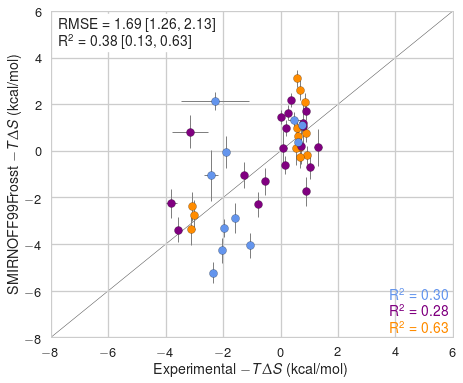

In [37]:
df = smirnoff_combined.merge(experimental, on=["System"], suffixes=("_smirnoff",
                                                                "_experimental"))
assert(len(df) == 43)

artist = scatter(df, 
        x="-TdS_experimental",
        y="-TdS_smirnoff",
        xerr="-TdS_SEM_experimental",
        yerr="-TdS_SEM_smirnoff",
        xlabel=r"Experimental $-T \Delta S$ (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $-T \Delta S$ (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-Experimental-TdS.pdf")

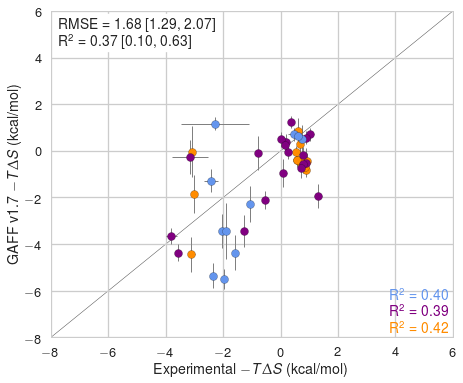

In [38]:
df = bgbg_combined.merge(experimental, on=["System"], suffixes=("_bgbg",
                                                                "_experimental"))
assert(len(df) == 43)

artist = scatter(df, 
        x="-TdS_experimental",
        y="-TdS_bgbg",
        xerr="-TdS_SEM_experimental",
        yerr="-TdS_SEM_bgbg",
        xlabel=r"Experimental $-T \Delta S$ (kcal/mol)",
        ylabel=r"GAFF v1.7 $-T \Delta S$ (kcal/mol)",
        colors=colors,
        name="GAFF-v1.7-vs-Experimental-TdS.pdf")

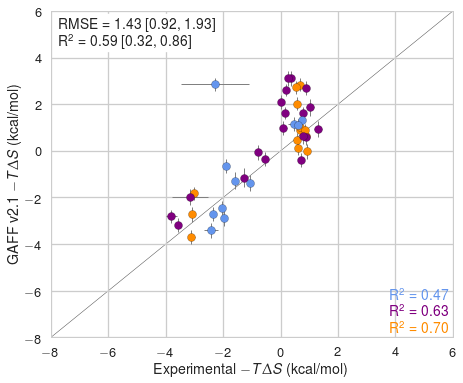

In [39]:
df = bg2bg2_combined.merge(experimental, on=["System"], suffixes=("_bg2bg2",
                                                                "_experimental"))
assert(len(df) == 43)

artist = scatter(df, 
        x="-TdS_experimental",
        y="-TdS_bg2bg2",
        xerr="-TdS_SEM_experimental",
        yerr="-TdS_SEM_bg2bg2",
        xlabel=r"Experimental $-T \Delta S$ (kcal/mol)",
        ylabel=r"GAFF v2.1 $-T \Delta S$ (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-Experimental-TdS.pdf")

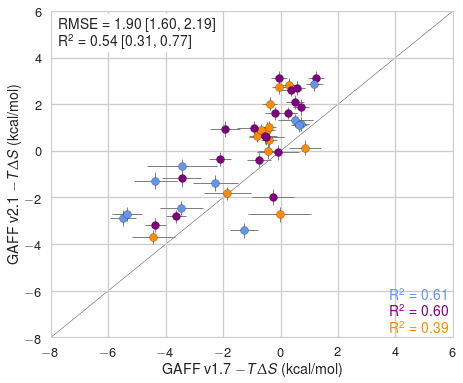

In [40]:
df = bg2bg2_combined.merge(bgbg_combined, on=["System", "Type"], suffixes=("_bg2bg2",
                                                                "_bgbg"))
assert(len(df) == 43)

artist = scatter(df, 
        x="-TdS_bgbg",
        y="-TdS_bg2bg2",
        xerr="-TdS_SEM_bgbg",
        yerr="-TdS_SEM_bg2bg2",
        xlabel=r"GAFF v1.7 $-T \Delta S$ (kcal/mol)",
        ylabel=r"GAFF v2.1 $-T \Delta S$ (kcal/mol)",
        colors=colors,
        )

# By orientation...

In [41]:
smirnoff["-TdS"] = smirnoff["Delta G"] - smirnoff["Delta H"]
smirnoff["-TdS_SEM"] = np.sqrt(smirnoff["G_SEM"]**2 + smirnoff["H_SEM"]**2)

bgbg["-TdS"] = bgbg["Delta G"] - bgbg["Delta H"]
bgbg["-TdS_SEM"] = np.sqrt(bgbg["G_SEM"]**2 + bgbg["H_SEM"]**2)

bg2bg2["-TdS"] = bg2bg2["Delta G"] - bg2bg2["Delta H"]
bg2bg2["-TdS_SEM"] = np.sqrt(bg2bg2["G_SEM"]**2 + bg2bg2["H_SEM"]**2)

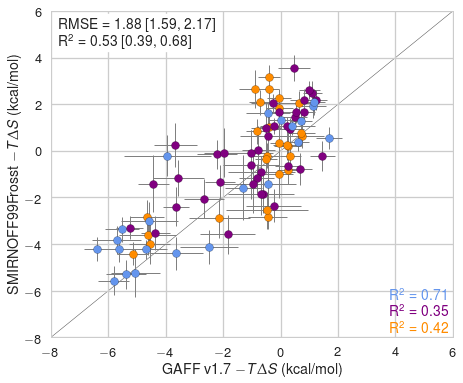

In [42]:
df = smirnoff.merge(bgbg, on=["System", "Type"], suffixes=("_smirnoff",
                                                   "_bgbg"))
assert(len(df) == 86)

artist = scatter(df, 
        x="-TdS_bgbg",
        y="-TdS_smirnoff",
        xerr="-TdS_SEM_bgbg",
        yerr="-TdS_SEM_smirnoff",
        xlabel=r"GAFF v1.7 $-T \Delta S$ (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $-T \Delta S$ (kcal/mol)",
        colors=colors,
        )

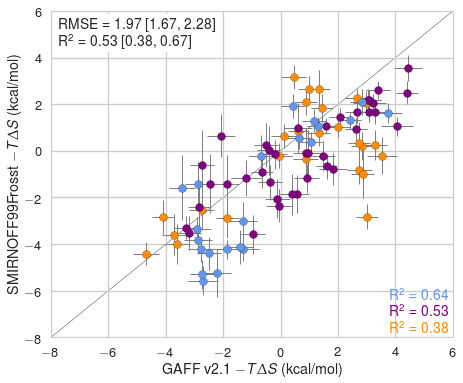

In [43]:
df = smirnoff.merge(bg2bg2, on=["System", "Type"], suffixes=("_smirnoff",
                                                   "_bg2bg2"))
assert(len(df) == 86)

artist = scatter(df, 
        x="-TdS_bg2bg2",
        y="-TdS_smirnoff",
        xerr="-TdS_SEM_bg2bg2",
        yerr="-TdS_SEM_smirnoff",
        xlabel=r"GAFF v2.1 $-T \Delta S$ (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $-T \Delta S$ (kcal/mol)",
        colors=colors,
        )

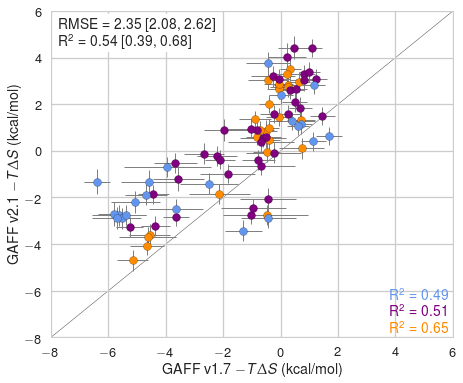

In [44]:
df = bg2bg2.merge(bgbg, on=["System", "Type"], suffixes=("_bg2bg2",
                                                   "_bgbg"))
assert(len(df) == 86)

artist = scatter(df, 
        x="-TdS_bgbg",
        y="-TdS_bg2bg2",
        xerr="-TdS_SEM_bgbg",
        yerr="-TdS_SEM_bg2bg2",
        xlabel=r"GAFF v1.7 $-T \Delta S$ (kcal/mol)",
        ylabel=r"GAFF v2.1 $-T \Delta S$ (kcal/mol)",
        colors=colors,
        )